# Diamond Pricing Analysis
## Authored by Trinity Gahagen
#### Phase 3 Project for Flatiron School
---
---

# Data Overview
---

*Dataset Kaggle Page:* https://www.kaggle.com/datasets/miguelcorraljr/brilliant-diamonds

This dataset was scraped back in 2020 off of Brilliant Earth's diamond catalogue. It hosts the folllowing columns:

|Attribute|	Description	|Data Type|
|---------|-------------|---------|
|id|Diamond identification number provided by Brilliant Earth|int
|url|URL for the diamond details page|string
|shape|External geometric appearance of a diamond|string/categorical
|price|Price in U.S. dollars|int
|carat|Unit of measurement used to describe the weight of a diamond|float
|cut|Facets, symmetry, and reflective qualities of a diamond|string/categorical
|color|Natural color or lack of color visible within a diamond, based on the GIA grade scale|string/categorical
|clarity|Visibility of natural microscopic inclusions and imperfections within a diamond|string/categorical
|report|Diamond certificate or grading report provided by an independent gemology lab|string
|type|Natural or lab created diamonds|string
|date_fetched|Date the data was fetched|date

### Initial Data Exploration/Cleaning

In [239]:
# Base Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Plot styles
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['font.size'] = 11
from matplotlib.ticker import FuncFormatter

# Statistical modules
import scipy.stats as stats

In [240]:
# Read in dataset
diamonds = pd.read_csv('diamonds_dataset.csv')

In [241]:
# Look at columns, datatypes, and null-values
diamonds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119307 entries, 0 to 119306
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            119307 non-null  int64  
 1   url           119307 non-null  object 
 2   shape         119307 non-null  object 
 3   price         119307 non-null  int64  
 4   carat         119307 non-null  float64
 5   cut           119307 non-null  object 
 6   color         119307 non-null  object 
 7   clarity       119307 non-null  object 
 8   report        119307 non-null  object 
 9   type          119307 non-null  object 
 10  date_fetched  119307 non-null  object 
dtypes: float64(1), int64(2), object(8)
memory usage: 10.0+ MB


In [242]:
# Numerical column descriptive stats
diamonds.describe()

,id,price,carat
count,1.193070e+05,1.193070e+05,119307.000000
mean,9.905507e+06,3.286843e+03,0.884169
std,2.373824e+05,9.114695e+03,0.671141
min,4.367730e+05,2.700000e+02,0.250000
25%,9.854352e+06,9.000000e+02,0.400000
50%,9.978096e+06,1.770000e+03,0.700000
75%,1.005433e+07,3.490000e+03,1.100000
max,1.009225e+07,1.348720e+06,15.320000


In [243]:
# Categorical column descriptive stats
diamonds.describe(include='O')

,url,shape,cut,color,clarity,report,type,date_fetched
count,119307,119307,119307,119307,119307,119307,119307,119307
unique,119307,10,5,7,8,4,2,1
top,https://www.brilliantearth.com//loose-diamonds...,Round,Super Ideal,E,VS1,GIA,natural,2020-11-29 12-26 PM
freq,1,76080,55244,24730,27259,68782,70313,119307


In [244]:
# What are the unique categories in each of the categorical columns?
categorical_cols = ['shape', 'cut', 'color', 'clarity', 'report', 'type']
for col in categorical_cols:
    print(f"Unique values in {col}: {diamonds[col].unique()}")

Unique values in shape: ['Round' 'Emerald' 'Marquise' 'Princess' 'Pear' 'Heart' 'Oval' 'Cushion'
 'Asscher' 'Radiant']
Unique values in cut: ['Very Good' 'Ideal' 'Super Ideal' 'Good' 'Fair']
Unique values in color: ['J' 'I' 'E' 'F' 'G' 'H' 'D']
Unique values in clarity: ['SI2' 'SI1' 'VS2' 'VVS1' 'VS1' 'VVS2' 'IF' 'FL']
Unique values in report: ['GIA' 'HRD' 'IGI' 'GCAL']
Unique values in type: ['natural' 'lab']


In [245]:
# ID, url, and date_fetched are all useless columns: drop them
try:
    diamonds.drop(columns=['id', 'url', 'date_fetched'], inplace=True)
except:
    print('Columns already dropped')

In [246]:
# Create categorical columns with inherent order
diamonds['cut'] = pd.Categorical(diamonds['cut'], categories=['Fair', 'Good', 'Very Good', 'Ideal', 'Super Ideal'], ordered=True)
diamonds['clarity'] = pd.Categorical(diamonds['clarity'], categories=['SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF', 'FL'], ordered=True)
diamonds['color'] = pd.Categorical(diamonds['color'], categories=['J', 'I', 'H', 'G','F', 'E', 'D'], ordered=True)

# Create categorical columns WITHOUT inherent order
diamonds['shape'] = pd.Categorical(diamonds['shape'], categories=diamonds['shape'].unique(), ordered=False)
diamonds['report'] = pd.Categorical(diamonds['report'], categories=diamonds['report'].unique(), ordered=False)
diamonds['type'] = pd.Categorical(diamonds['type'], categories=diamonds['type'].unique(), ordered=False)

In [247]:
diamonds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119307 entries, 0 to 119306
Data columns (total 8 columns):
 #   Column   Non-Null Count   Dtype   
---  ------   --------------   -----   
 0   shape    119307 non-null  category
 1   price    119307 non-null  int64   
 2   carat    119307 non-null  float64 
 3   cut      119307 non-null  category
 4   color    119307 non-null  category
 5   clarity  119307 non-null  category
 6   report   119307 non-null  category
 7   type     119307 non-null  category
dtypes: category(6), float64(1), int64(1)
memory usage: 2.5 MB


<a id="eda-descriptive-analysis"></a>
# EDA: Descriptive Analysis
---

In [248]:
def countplot(df=diamonds, column=None, fig=None, ax=None):
    """
    Creates a bar chart of the different value counts of the categorical column passed in, shows plot in order from largest value to smallest
    """
    if (fig == None) & (ax == None):
        fig, ax = plt.subplots(figsize=(10, 6))
    column_counts = df[column].value_counts().sort_values(ascending=False)
    ax.bar(x=column_counts.index, height=column_counts, lw=1.2, edgecolor='black', color=sns.color_palette('muted'))
    for i in column_counts.index:
        if df[column].dtype == float:
            value = f'{column_counts[i]:,.02f}'
        else:
            value = f'{column_counts[i]:,.0f}'
        ax.annotate(value,
                    xy=(i, column_counts[i] + (0.02 * ax.get_ylim()[1])),
                    #fontweight='bold',
                    va='center',
                    ha='center')
    ax.tick_params(axis='x', rotation=45)
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _:f'{y:,.0f}'))
    ax.set_xlabel(f'{col}'.title())
    ax.set_ylabel('Count')
    ax.set_title(f'Countplot of {col.title()} Categories')
        

### What are the counts of each category in each categorical column? <a name="descriptive-question-1"></a>

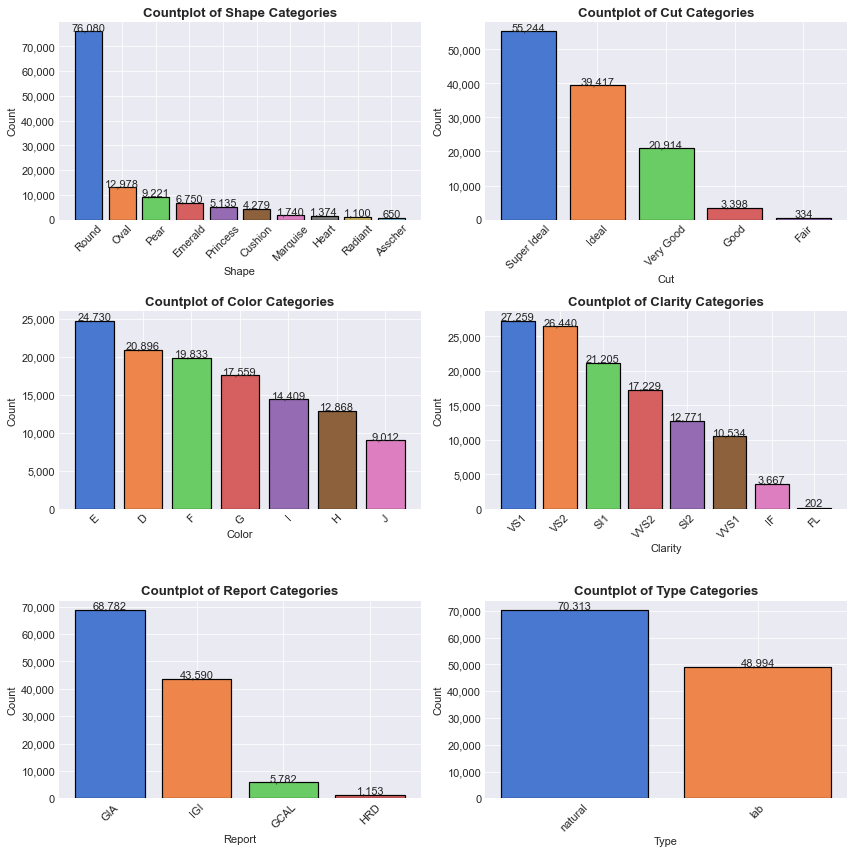

In [249]:
fig, axes = plt.subplots(3, 2, figsize=(12, 12))

for n, col in enumerate(categorical_cols):
    ax = axes[n//2][n%2]
    countplot(column=col, fig=fig, ax=ax)
plt.tight_layout()

The categories with the largest proportions in each of the columns are:
- Round shape
- Super ideal cut
- E color
- VS1 clarity rating
- GIA report
- Natural diamonds

### What are the top five most expensive diamonds? What are the five least expensive?

In [250]:
diamonds.sort_values(by='price', ascending=False).head()

,shape,price,carat,cut,color,clarity,report,type
70312,Emerald,1348720,11.41,Super Ideal,D,FL,GIA,natural
70311,Cushion,792400,10.15,Super Ideal,D,FL,GIA,natural
70310,Round,728890,10.10,Super Ideal,D,VVS2,GIA,natural
70309,Round,648290,10.12,Super Ideal,F,VVS1,GIA,natural
70308,Emerald,612570,10.09,Super Ideal,E,VVS2,GIA,natural


In [251]:
diamonds.sort_values(by='price').head()

,shape,price,carat,cut,color,clarity,report,type
70313,Oval,270,0.29,Super Ideal,H,SI1,IGI,lab
70325,Pear,280,0.30,Good,H,SI1,IGI,lab
70330,Pear,280,0.30,Ideal,G,SI2,IGI,lab
70329,Pear,280,0.30,Ideal,J,VS2,IGI,lab
70328,Pear,280,0.30,Very Good,H,SI2,IGI,lab


### Is there a relationship between a diamond's carat weight and its price? Do different categories affect price?

In [252]:
def carats_vs_price_scatterplot(df=diamonds, x='carat', y='price', fig=None, ax=None, title='Carat Weight of Diamond vs. Price'):
    if (fig == None) & (ax == None):
        fig, ax = plt.subplots(figsize=(10, 6))
    
    sns.scatterplot(data=df, x=x, y=y, ax=ax, marker='D', color='purple', edgecolor=None, alpha=0.5)
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _:f'${y:,.0f}'))
    ax.set_title(title)
    ax.set_xlabel(x.title())
    ax.set_ylabel(y.title());

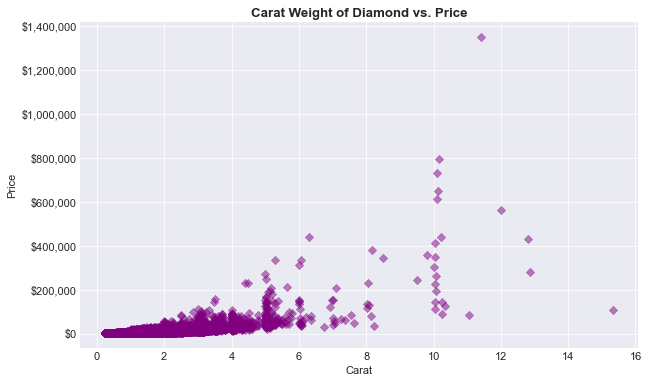

In [253]:
carats_vs_price_scatterplot()

There are several outliers that are skewing the price distribution of diamonds, rendering it hard to see the trend in the graph above. Let's try and isolate them, and see how many of them there are.

In [254]:
diamonds['std_price'] = (diamonds['price'] - diamonds['price'].mean()) / (diamonds['price'].std())

three_point_five_stds_above = diamonds.loc[diamonds['std_price'] > 3.5]
display(three_point_five_stds_above)

,shape,price,carat,cut,color,clarity,report,type,std_price
69991,Oval,35260,2.61,Super Ideal,F,VS2,GIA,natural,3.507869
69992,Emerald,35290,2.74,Good,D,VVS2,GIA,natural,3.511160
69993,Round,35360,3.00,Super Ideal,F,SI1,GIA,natural,3.518840
69994,Cushion,35450,3.00,Ideal,G,SI1,GIA,natural,3.528714
69995,Round,35540,2.90,Super Ideal,H,VS2,GIA,natural,3.538589
...,...,...,...,...,...,...,...,...,...
119302,Round,99040,5.71,Super Ideal,D,VVS2,GCAL,lab,10.505360
119303,Cushion,107330,15.32,Very Good,G,SI2,IGI,lab,11.414880
119304,Cushion,110110,10.05,Ideal,D,SI2,IGI,lab,11.719882
119305,Oval,126030,10.33,Fair,D,VS2,IGI,lab,13.466512


Using the Z-Score method of removing outliers, setting the threshold to be 3.5 standard deviations away from the mean, there are about 495 outliers based on the price column. Since the data is so skewed to the right with these extremely large values, we'll save a couple of different transformations for distribution analysis later: namely, a square-root transformation, and a natural-log transformation.

In [255]:
# Square root transformation of price
diamonds['sqrt_price'] = np.sqrt(diamonds['price'])

In [256]:
# Natural log transformation of price
diamonds['log_price'] = np.log(diamonds['price'])
diamonds['log_price'].describe()

count    119307.000000
mean          7.537824
std           0.953602
min           5.598422
25%           6.802395
50%           7.478735
75%           8.157657
max          14.114667
Name: log_price, dtype: float64

In [257]:
# Detecting outliers using the IQR
iqr = np.quantile(diamonds['price'], 0.75) - np.quantile(diamonds['price'], 0.25)
low_threshold = np.quantile(diamonds['price'], 0.25) - (1.5 * iqr)
high_threshold = np.quantile(diamonds['price'], 0.75) + (1.5 * iqr)

In [258]:
NO_OUTLIERS = (low_threshold < diamonds['price']) & (diamonds['price'] < high_threshold)
no_outliers = diamonds.loc[NO_OUTLIERS]
print(f"No. of outliers using the IQR: {diamonds.loc[~NO_OUTLIERS].shape[0]}")
print(no_outliers.shape)

No. of outliers using the IQR: 10187
(109120, 11)


Using the outlier formula based on the IQR, there are considerably more data points removed. Let's look at the datapoints using both the Z-Score and IQR methods for outlier removal, to see if we can get a better sense of the relationship between carats and price.

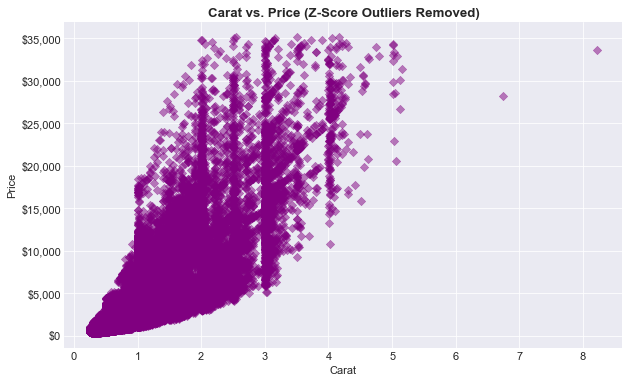

In [288]:
carats_vs_price_scatterplot(df=diamonds.drop(three_point_five_stds_above.index), title='Carat vs. Price (Z-Score Outliers Removed)')

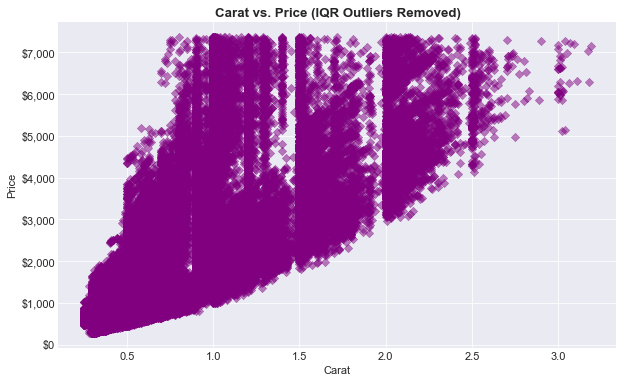

In [289]:
carats_vs_price_scatterplot(df=no_outliers, title='Carat vs. Price (IQR Outliers Removed)')

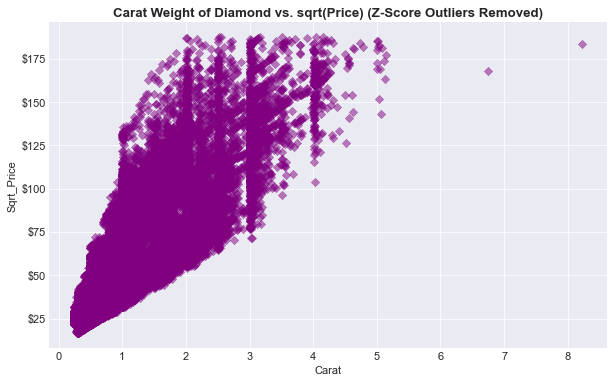

In [290]:
carats_vs_price_scatterplot(df=diamonds.drop(three_point_five_stds_above.index), y='sqrt_price', title='Carat Weight of Diamond vs. sqrt(Price) (Z-Score Outliers Removed)')

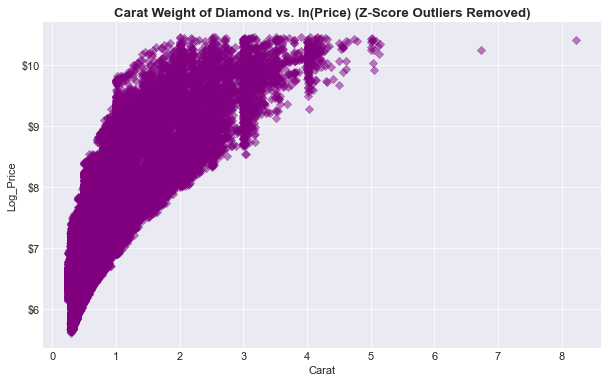

In [291]:
carats_vs_price_scatterplot(df=diamonds.drop(three_point_five_stds_above.index), y='log_price', title='Carat Weight of Diamond vs. ln(Price) (Z-Score Outliers Removed)')

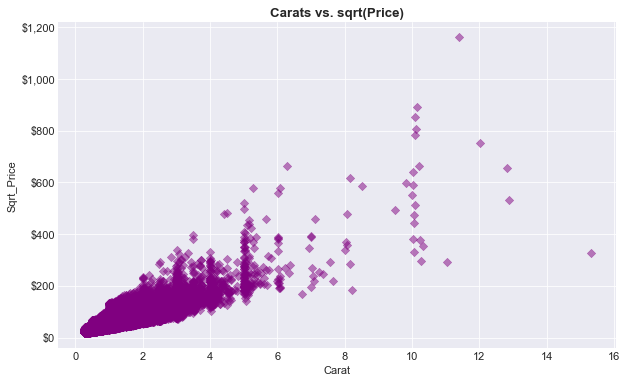

In [263]:
carats_vs_price_scatterplot(y='sqrt_price', title='Carats vs. sqrt(Price)')

In [264]:
def carat_vs_price_by_column(df=diamonds, column=None, fig=None, ax=None, title='', ylabel=''):
    if (fig == None) & (ax == None):
        fig, ax = plt.subplots(figsize=(10, 6))

    sns.scatterplot(data=df, x='carat', y='price', edgecolor=None, hue=column, ax=ax, palette='muted', marker='D', alpha=0.75)
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'${y * 1e-3:.0f}k'))
    ax.set_title(title)
    ax.set_xlabel('Carats')
    ax.set_ylabel(ylabel)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1));

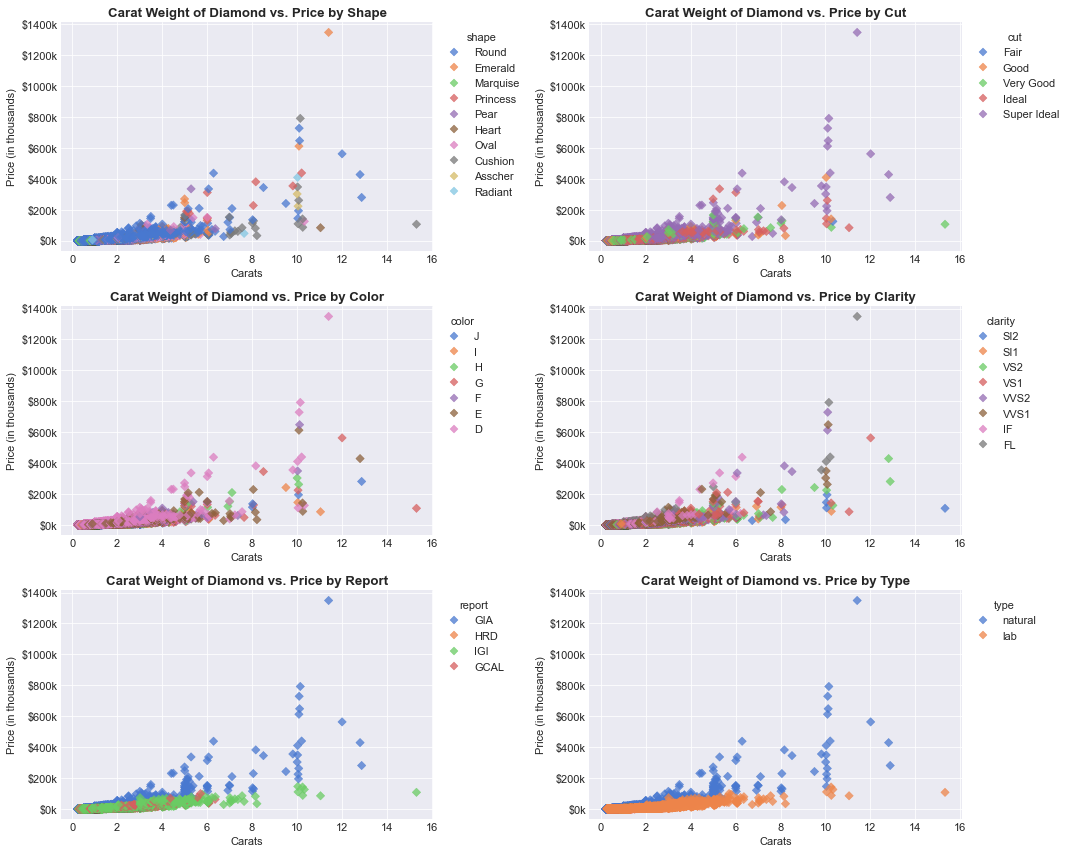

In [266]:
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
for n, col in enumerate(categorical_cols):
    ax = axes[n//2][n%2]
    carat_vs_price_by_column(df=diamonds,
                             column=col,
                             fig=fig,
                             ax=ax,
                             title=f'Carat Weight of Diamond vs. Price by {col.title()}',
                             ylabel=f'Price (in thousands)',
                             )
plt.tight_layout();

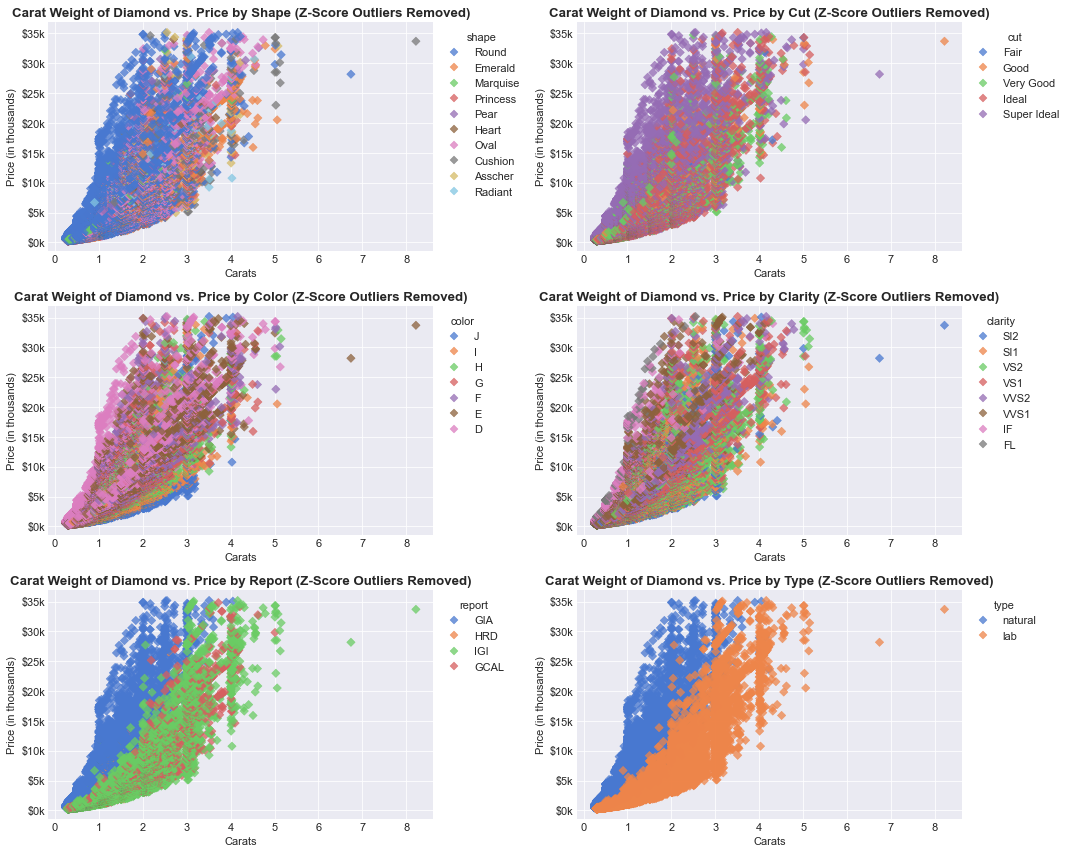

In [265]:
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
for n, col in enumerate(categorical_cols):
    ax = axes[n//2][n%2]
    carat_vs_price_by_column(df=diamonds.drop(three_point_five_stds_above.index),
                             column=col,
                             fig=fig,
                             ax=ax,
                             title=f'Carat Weight of Diamond vs. Price by {col.title()} (Z-Score Outliers Removed)',
                             ylabel=f'Price (in thousands)',
                             )
plt.tight_layout();

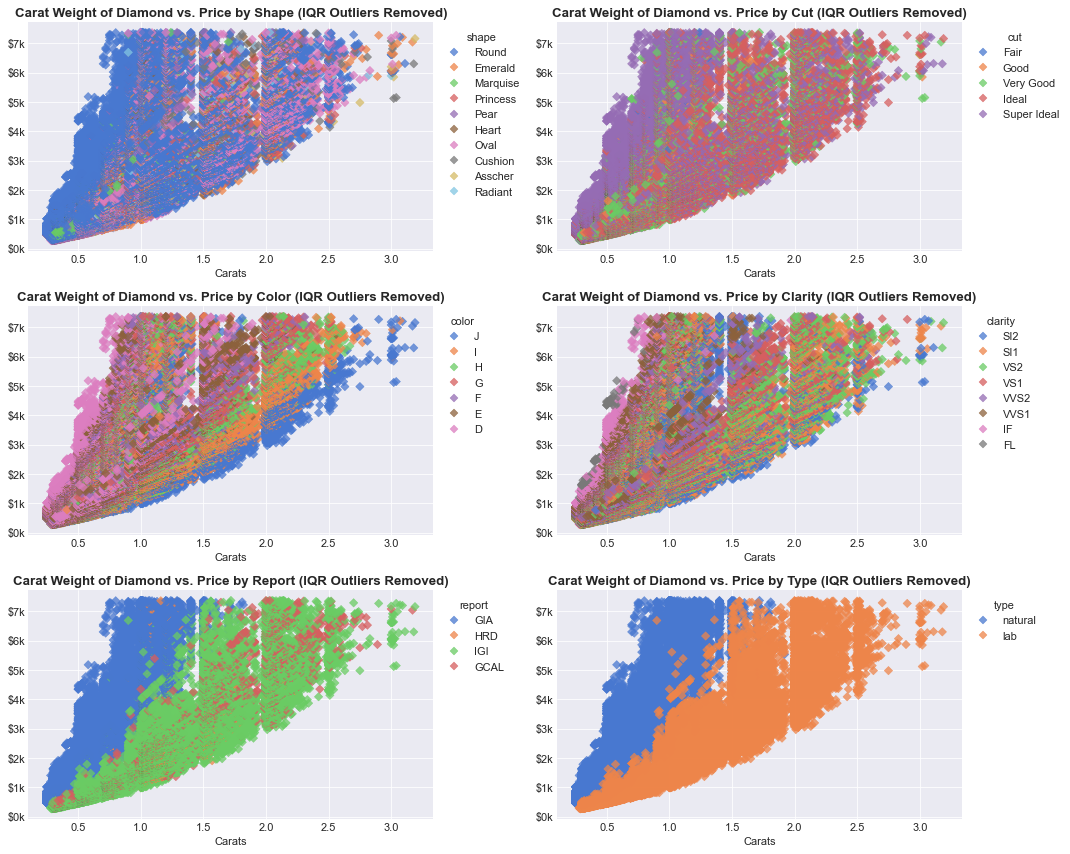

In [267]:
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
for n, col in enumerate(categorical_cols):
    ax = axes[n//2][n%2]
    carat_vs_price_by_column(df=no_outliers,
                             column=col,
                             fig=fig, ax=ax,
                             title=f'Carat Weight of Diamond vs. Price by {col.title()} (IQR Outliers Removed)')
plt.tight_layout();

With outliers removed, it is easier to see that there is a clear positive correlation between carats and price. There are also indicators that round and oval shaped diamonds will tend to cost more than other shapes, GIA reports will tend to cost more, and natural diamonds will tend to cost more. Of course, the pricing also falls in line with the ordered categories of cut, clarity, and color, where super ideal cut diamonds will tend to cost more, "D" colored diamonds will tend to cost more, and flawless/internally flawless diamonds will tend to cost more. However, is this really the case?

### What are the price distributions of each category in each categorical column?

In [268]:
def boxplot_by_category(df=diamonds, x='price', column=None, fig=None, ax=None, title='', xlabel='', ylabel=''):
    if (fig == None) & (ax == None):
        fig, ax = plt.subplots(figsize=(10, 6))

    sns.boxplot(data=df, x=x, ax=ax, hue=column, palette='muted', gap=0.2, fliersize=0.75)
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x}'))
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1));

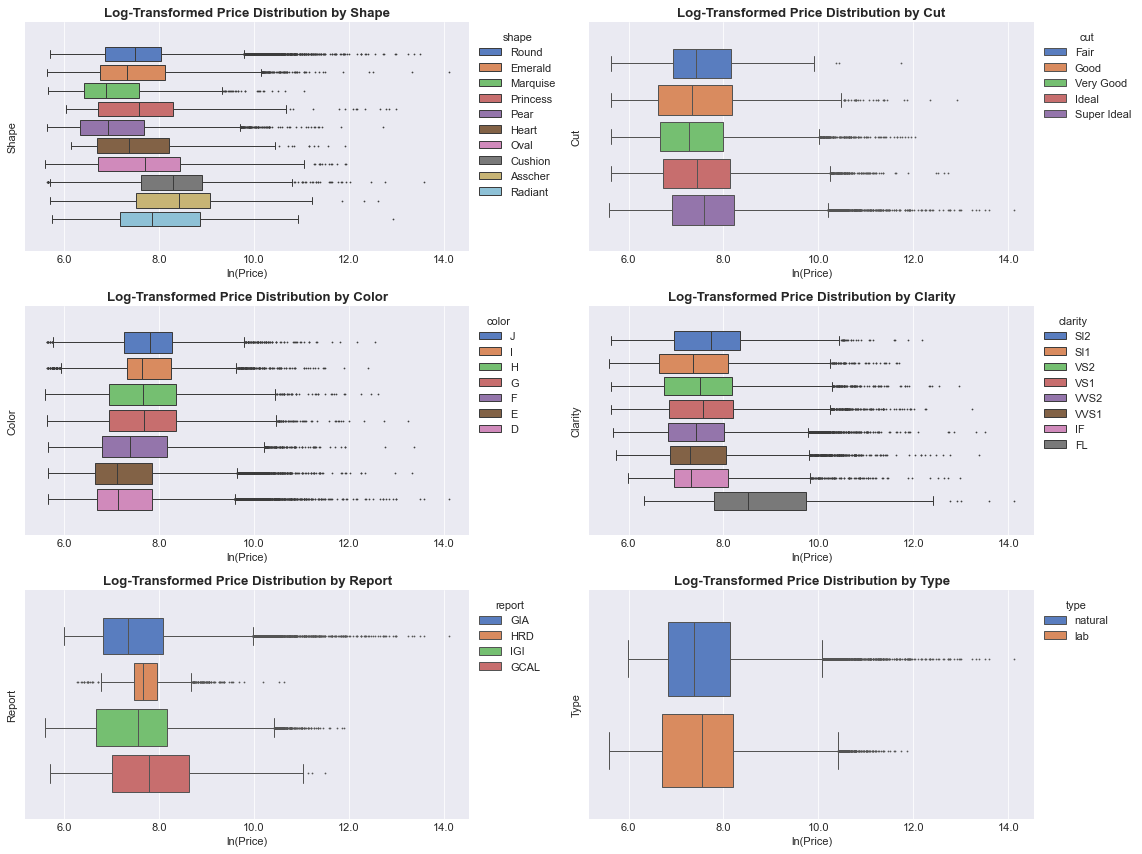

In [269]:
fig, axes = plt.subplots(3, 2, figsize=(16, 12))
for n, col in enumerate(categorical_cols):
    ax = axes[n//2][n%2]
    boxplot_by_category(df=diamonds,
                        x='log_price',
                        column=col,
                        fig=fig, ax=ax,
                        title=f'Log-Transformed Price Distribution by {col.title()}',
                        xlabel='ln(Price)',
                        ylabel=f'{col.title()}')
plt.tight_layout();

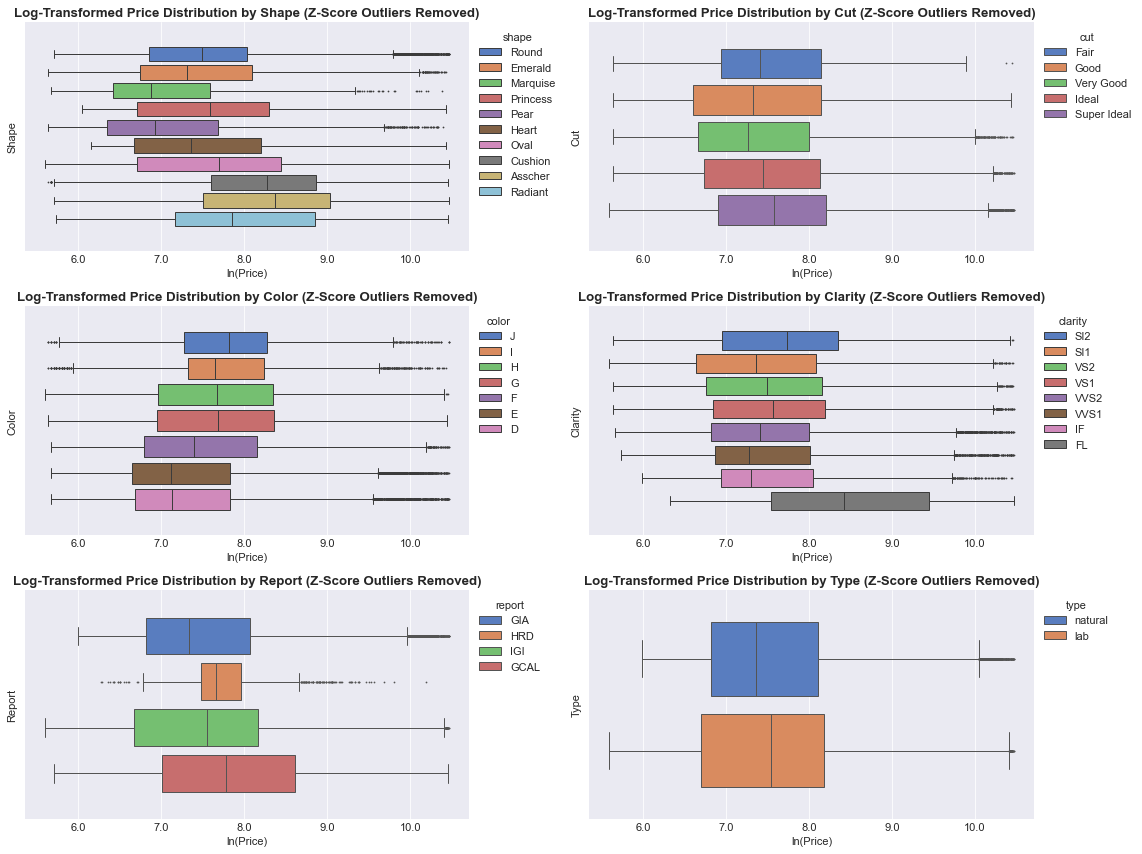

In [287]:
fig, axes = plt.subplots(3, 2, figsize=(16, 12))
for n, col in enumerate(categorical_cols):
    ax = axes[n//2][n%2]
    boxplot_by_category(df=diamonds.drop(three_point_five_stds_above.index),
                        x='log_price',
                        column=col,
                        fig=fig, ax=ax,
                        title=f'Log-Transformed Price Distribution by {col.title()} (Z-Score Outliers Removed)',
                        xlabel='ln(Price)',
                        ylabel=f'{col.title()}')
plt.tight_layout();

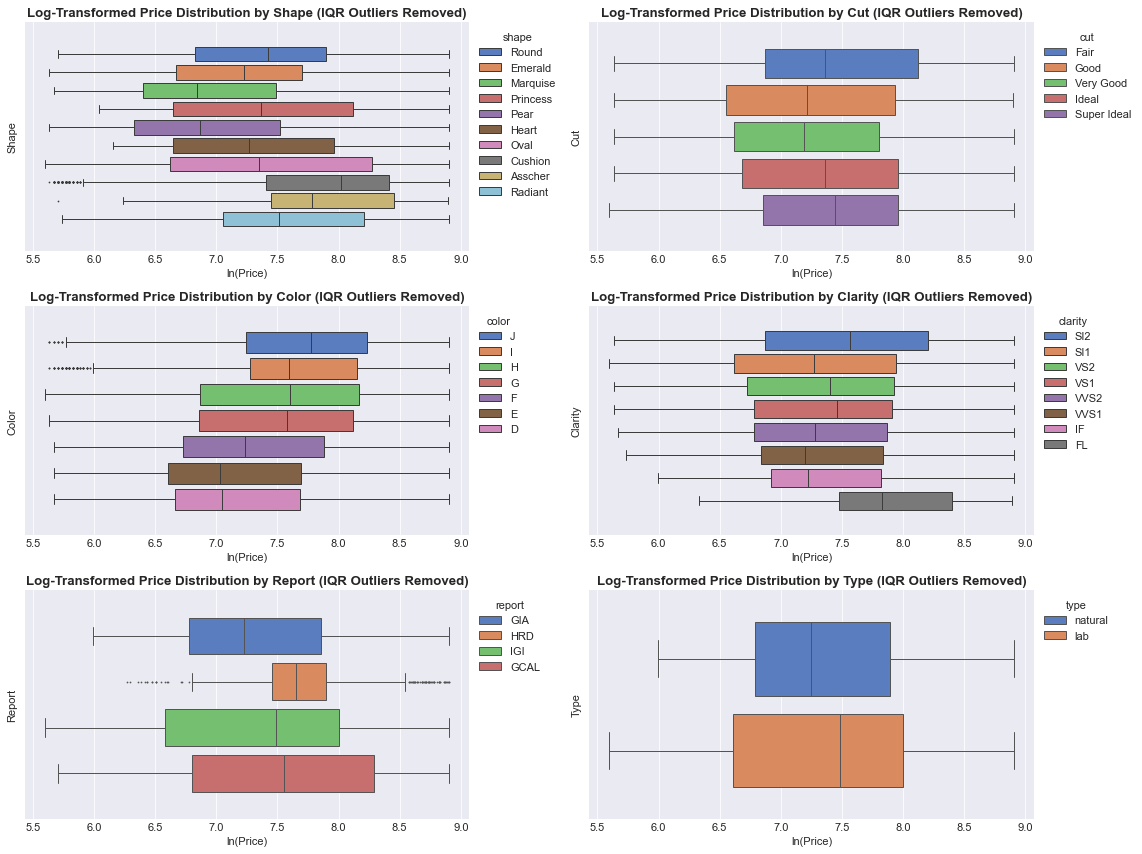

In [271]:
fig, axes = plt.subplots(3, 2, figsize=(16, 12))
for n, col in enumerate(categorical_cols):
    ax = axes[n//2][n%2]
    boxplot_by_category(df=no_outliers,
                        x='log_price',
                        column=col,
                        fig=fig, ax=ax,
                        title=f'Log-Transformed Price Distribution by {col.title()} (IQR Outliers Removed)',
                        xlabel='ln(Price)',
                        ylabel=f'{col.title()}')
plt.tight_layout();

# EDA: Inferential Analysis

In [272]:
def plot_distributions(df=diamonds, x='price', column=None, fig=None, ax=None, title='', xlabel=''):
    if (fig == None) & (ax == None):
        fig, ax = plt.subplots(figsize=(10, 6))
    
    sns.kdeplot(data=df, x=x, hue=column, ax=ax, palette='muted')
    
    ax.set_title(title)
    ax.set_xlabel(xlabel)

In [273]:
def non_parametric_anova(distributions, alpha=0.05):
    conclusion = ""
    _, p_val = stats.kruskal(*distributions)

    if p_val < alpha:
        conclusion = "Reject the null hypothesis"
    else:
        conclusion = "Fail to reject the null hypothesis"   

    return conclusion

In [274]:
def non_parametric_ttest(distributions, alpha=0.05):
    conclusion = ""
    _, p_val = stats.mannwhitneyu(*distributions)

    if p_val < alpha:
        conclusion = "Reject the null hypothesis"
    else:
        conclusion = "Fail to reject the null hypothesis"   

    return conclusion

In the following inferential analysis, we will be testing for differences in the distribution of price for each categorical variable.

For each distribution, we will be looking at the log-transformed distribution of price for each category (due to the extreme skewness of the price column). We will compare each of them for differences at a significance level of 0.05.

Even after transforming the data, the distributions do not appear to be normal. Thus, for each statistical test, we will perform the non-parametric version of the ANOVA or the Student t-test.

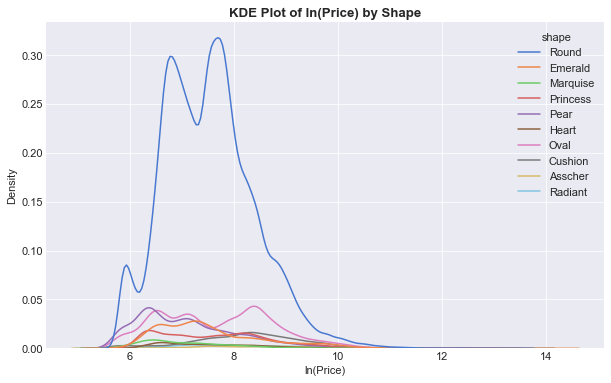

In [294]:
plot_distributions(column='shape', x='log_price', title=f'KDE Plot of ln(Price) by Shape', xlabel='ln(Price)')

**Statistical Test**

$H_0$: The medians of the log-transformed price distributions of each diamond shape are all equal.

$H_a$: The medians of the log-transformed price distributions of each diamond shape are *not* equal.

$\alpha = 0.05$

In [276]:
shape_distributions = [diamonds.loc[diamonds['shape'] == x, 'log_price'] for x in diamonds['shape'].unique()]

non_parametric_anova(shape_distributions, alpha=0.05)

'Reject the null hypothesis'

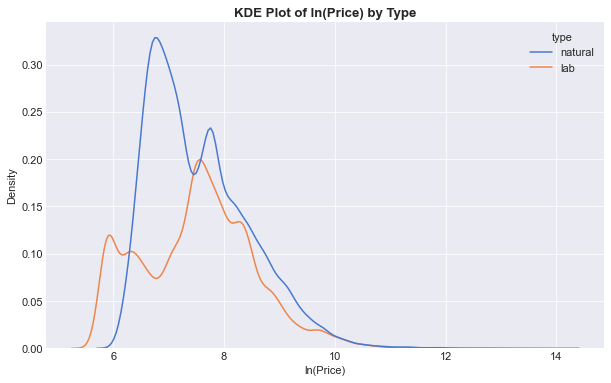

In [295]:
plot_distributions(column='type', x='log_price', title=f'KDE Plot of ln(Price) by Type', xlabel='ln(Price)')

**Statistical Test**

$H_0$: The log-transformed price distribution of natural diamonds is the same as lab-created diamonds.

$H_a$: The log-transformed price distribution of natural diamonds is *not* the same as lab-created diamonds.

$\alpha = 0.05$

In [278]:
type_distributions = [diamonds.loc[diamonds['type'] == x, 'log_price'] for x in diamonds['type'].unique()]

non_parametric_ttest(type_distributions, alpha=0.05)

'Fail to reject the null hypothesis'

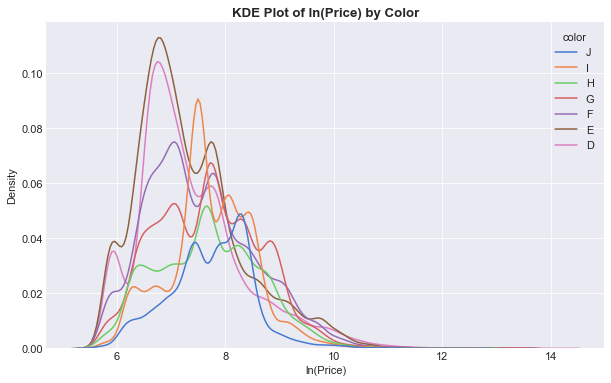

In [297]:
plot_distributions(column='color', x='log_price', title=f'KDE Plot of ln(Price) by Color', xlabel='ln(Price)')

**Statistical Test**

$H_0$: The medians of the log-transformed price distributions of each diamond color are all equal.

$H_a$: The medians of the log-transformed price distributions of each diamond color are *not* equal.

$\alpha = 0.05$

In [280]:
color_distributions = [diamonds.loc[diamonds['color'] == x, 'log_price'] for x in diamonds['color'].unique()]

non_parametric_anova(color_distributions, alpha=0.05)

'Reject the null hypothesis'

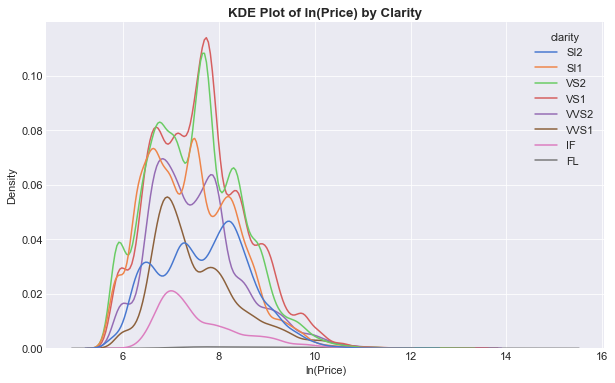

In [298]:
plot_distributions(column='clarity', x='log_price', title=f'KDE Plot of ln(Price) by Clarity', xlabel='ln(Price)')

**Statistical Test**

$H_0$: The medians of the log-transformed price distributions of each diamond clarity are all equal.

$H_a$: The medians of the log-transformed price distributions of each diamond clarity are *not* equal.

$\alpha = 0.05$

In [282]:
clarity_distributions = [diamonds.loc[diamonds['clarity'] == x, 'log_price'] for x in diamonds['clarity'].unique()]

non_parametric_anova(clarity_distributions, alpha=0.05)

'Reject the null hypothesis'

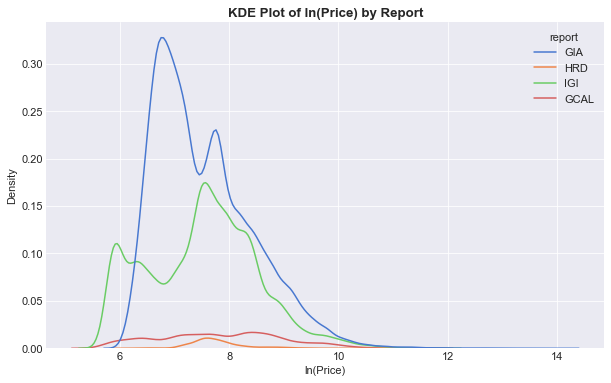

In [299]:
plot_distributions(column='report', x='log_price', title=f'KDE Plot of ln(Price) by Report', xlabel='ln(Price)')

**Statistical Test**

$H_0$: The medians of the log-transformed price distributions of each type of diamond report are all equal.

$H_a$: The medians of the log-transformed price distributions of each type of diamond report are *not* equal.

$\alpha = 0.05$

In [284]:
report_distributions = [diamonds.loc[diamonds['report'] == x, 'log_price'] for x in diamonds['report'].unique()]

non_parametric_anova(report_distributions, alpha=0.05)

'Reject the null hypothesis'

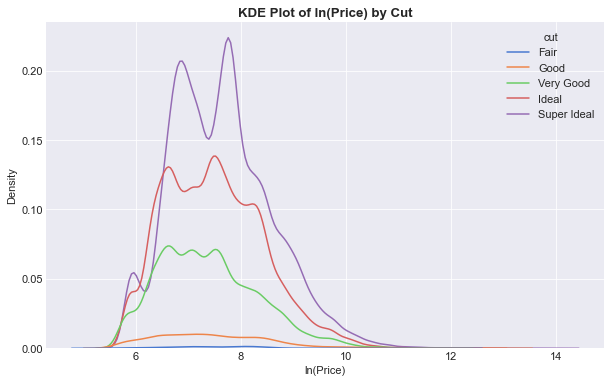

In [300]:
plot_distributions(column='cut', x='log_price', title=f'KDE Plot of ln(Price) by Cut', xlabel='ln(Price)')

**Statistical Test**

$H_0$: The medians of the log-transformed price distributions of each diamond cut are all equal.

$H_a$: The medians of the log-transformed price distributions of each diamond cut are *not* equal.

$\alpha = 0.05$

In [286]:
clarity_distributions = [diamonds.loc[diamonds['clarity'] == x, 'log_price'] for x in diamonds['clarity'].unique()]

non_parametric_anova(clarity_distributions, alpha=0.05)

'Reject the null hypothesis'

# Summary of Exploratory Data Analysis
---


# External Resources
https://blog.worthy.com/knowledge-center/diamonds/estimate-diamonds-value/

https://www.diamonds.pro/education/diamond-prices/